# Natural Language Processing - Knowledge Graph example

###### Links: [Dataset (Wikipedia page: Russo-Ukrainian War)](https://en.wikipedia.org/wiki/Russo-Ukrainian_War)  |  [Article (TowardsDataScience)](https://towardsdatascience.com/nlp-with-python-knowledge-graph-12b93146a458)

### 0 - Setup

###### Import pckgs

In [10]:
import warnings
warnings.filterwarnings("ignore")

## for data
import pandas as pd  #1.1.5
import numpy as np  #1.21.0

## for plotting
import matplotlib.pyplot as plt  #3.3.2
import seaborn as sns  #0.11.1

## for text
import wikipediaapi  #0.5.8
import nltk  #3.8.1
import re   

## for nlp
import spacy  #3.5.0
from spacy import displacy

## for graph
import networkx as nx  #3.0 (also pygraphviz==1.10)
import plotly.graph_objs as go  #5.1.0

## for timeline
import dateparser #1.1.7

###### Import data

In [11]:
import wikipedia 

In [12]:
wikipedia.set_lang("rus") 

In [13]:
# topic = "Railway"
# # topic = 'Железная дорога'
# wiki = wikipediaapi.Wikipedia('en')
# page = wiki.page(topic)
# # txt = page.text[:page.text.find("See also")]
# # txt[0:500] + " ..."

In [14]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/senya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
import docx2txt

# extract text
text = docx2txt.process("../practical_lesson_2/ГЛОССАРИЙ.docx")

In [19]:
'''
Compute n-grams frequency with nltk tokenizer.
:parameter
    :param txt: text
    :param ngrams: int or list - 1 for unigrams, 2 for bigrams, [1,2] for both
    :param top: num - plot the top frequent words
:return
    dtf_count: dtf with word frequency
'''
def word_freq(txt, ngrams=[1,2,3], top=10, figsize=(10,7)):
    lst_tokens = nltk.tokenize.word_tokenize(txt)
    ngrams = [ngrams] if type(ngrams) is int else ngrams
    
    ## calculate
    dtf_freq = pd.DataFrame()
    for n in ngrams:
        dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
        dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=["word","freq"])
        dtf_n["ngrams"] = n
        dtf_freq = dtf_freq.append(dtf_n)
    dtf_freq["word"] = dtf_freq["word"].apply(lambda x: " ".join(string for string in x) )
    dtf_freq = dtf_freq.sort_values(["ngrams","freq"], ascending=[True,False])
    
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax,
                data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(top))
    ax.set(xlabel=None, ylabel=None, title="Most frequent words")
    ax.grid(axis="x")
    plt.show()
    return dtf_freq

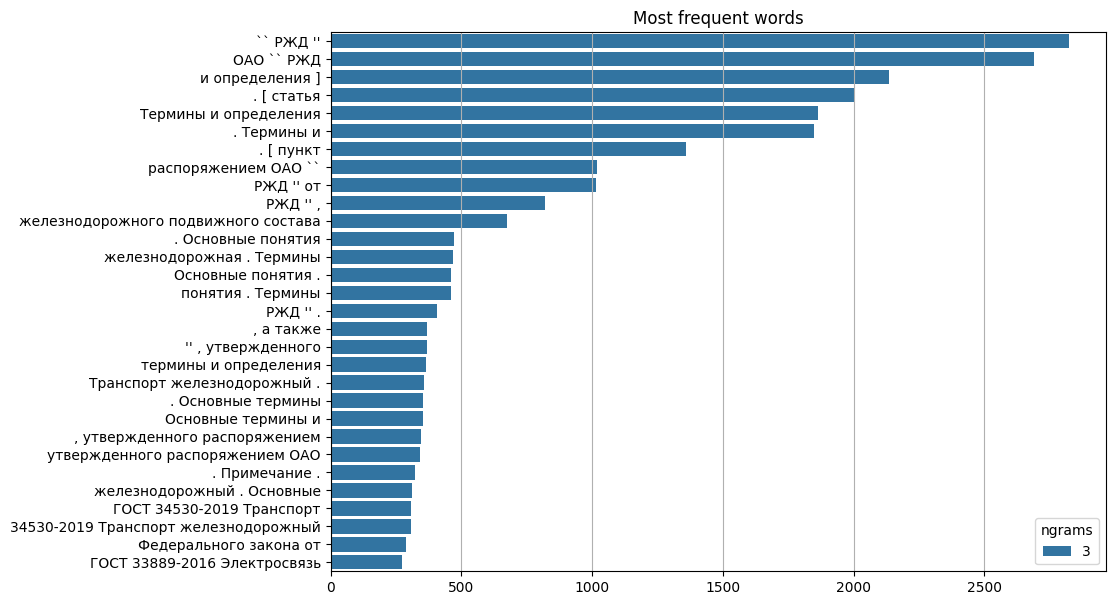

In [20]:
# Find most common words in text
_ = word_freq(text, ngrams=[3], top=30, figsize=(10,7))

### 1 - NLP

###### Model

In [9]:
# conda install -c conda-forge spacy
# pip install https://github.com/explosion/spacy-models/releases/download/ru_core_news_sm-3.1.0/ru_core_news_sm-3.1.0.tar.gz

In [22]:
from spacy.lang.ru.examples import sentences 

nlp = spacy.load("ru_core_news_sm")
doc = nlp(sentences[0])
print(doc.text)
for token in doc:
    print(token.text, token.pos_, token.dep_)

Apple рассматривает возможность покупки стартапа из Соединённого Королевства за $1 млрд
Apple PROPN nsubj
рассматривает VERB ROOT
возможность NOUN obj
покупки NOUN nmod
стартапа NOUN nmod
из ADP case
Соединённого ADJ amod
Королевства PROPN nmod
за ADP case
$ SYM nmod
1 NUM appos
млрд NOUN punct


In [23]:
doc = nlp(text[:1000000])

In [24]:
doc_1 = nlp(text[1000000:2000000])

In [31]:
# docs = list(nlp.pipe(text, n_process=3, batch_size=1000))

###### Sentence Segmentation

In [25]:
lst_docs = [sent for sent in doc_1.sents]
print("tot sentences:", len(lst_docs))

i = 3
lst_docs[i]

tot sentences: 8333




[статья 106 ГОСТ Р 53431-2009 Автоматика и телемеханика железнодорожная.

###### POS / DEP

In [26]:
i = 300
print(lst_docs[i], "\n---")

for token in lst_docs[i]:
    print(token.text, "-->", "часть речи: "+token.pos_, "|", "роль в предложении: "+token.dep_,
          "|", "зависимость: "+ token.head.text)

Местное замыкание

Способ реализации в распределенной системе централизации стрелок и сигналов ряда зависимостей местными устройствами железнодорожной автоматики и телемеханики при их общем контроле и управлении с центрального поста централизации. 
---
Местное --> часть речи: ADJ | роль в предложении: amod | зависимость: замыкание
замыкание --> часть речи: NOUN | роль в предложении: nsubj | зависимость: 




 --> часть речи: SPACE | роль в предложении: ROOT | зависимость: 


Способ --> часть речи: PROPN | роль в предложении: nsubj | зависимость: 


реализации --> часть речи: NOUN | роль в предложении: nmod | зависимость: Способ
в --> часть речи: ADP | роль в предложении: case | зависимость: системе
распределенной --> часть речи: ADJ | роль в предложении: amod | зависимость: системе
системе --> часть речи: NOUN | роль в предложении: nmod | зависимость: реализации
централизации --> часть речи: NOUN | роль в предложении: nmod | зависимость: системе
стрелок --> часть речи: NOUN | роль в пр

In [27]:
svg = displacy.render(lst_docs[i], style="dep", options={"distance":100})
output_path = Path("dependency_plot.svg") 
output_path.open("w", encoding="utf-8").write(svg)

NameError: name 'Path' is not defined

###### NER

In [28]:
lst_docs[1100]

Центр коммутации сети железнодорожной радиосвязи [подвижной связи]

Коммутационная станция, осуществляющая соединение подвижных абонентов внутри сети железнодорожной радиосвязи [подвижной связи] и их взаимодействие с абонентами сетей фиксированной связи.

In [29]:
displacy.render(doc_1[100400:100500], style='ent', jupyter=True)

In [30]:
for tag in doc_1[100000:100500]:
#     print(lst_docs[1100])
    print(tag.text, f"({tag.ent_type_})") 



изнашивания ()


 ()
[ ()
статья ()
5 ()
ГОСТ ()
27674 ()
- ()
88 ()
Трение ()
, ()
изнашивание ()
и ()
смазка ()
. ()
Термины ()
и ()
определения ()
] ()


 ()
64.9 ()
. ()
Смазка ()


 ()
Действие ()
смазочного ()
материала ()
, ()
в ()
результате ()
которого ()
между ()
двумя ()
поверхностями ()
уменьшаются ()
износ ()
, ()
повреждения ()
поверхности ()
и ()
( ()
или ()
) ()
сила ()
трения ()


 ()
[ ()
статья ()
6 ()
ГОСТ ()
27674 ()
- ()
88 ()
Трение ()
, ()
изнашивание ()
и ()
смазка ()
. ()
Термины ()
и ()
определения ()
] ()


 ()
64.10 ()
. ()
[ ()
смазывание ()
, ()
лубрикация ()
] ()


 ()
Подведение ()
смазочного ()
материала ()
к ()
поверхности ()
трения ()


 ()
[ ()
статья ()
7 ()
ГОСТ ()
27674 ()
- ()
88 ()
Трение ()
, ()
изнашивание ()
и ()
смазка ()
. ()
Термины ()
и ()
определения ()
] ()


 ()
64.11 ()
. ()
Лубрикация ()
рельсов ()
и ()
гребней ()
колес ()


 ()
Процесс ()
нанесения ()
на ()
боковую ()
грань ()
головки ()
рельса ()
и ()
( ()
или ()
) ()
гребень ()
к

### 2 - Entities, Relations, Attributes

###### Entities Extraction

In [31]:
## Using POS/DEP
def extract_entities(doc):
    a, b, prev_dep, prev_txt, prefix, modifier = "", "", "", "", "", ""
    for token in doc:
        if token.dep_ != "punct":
            ## префикс --> prev_compound + compound 
            if token.dep_ == "compound":
                prefix = prev_txt +" "+ token.text if prev_dep == "compound" else token.text
            
            ## modifier --> prev_compound + %mod 
            if token.dep_.endswith("mod") == True:
                modifier = prev_txt +" "+ token.text if prev_dep == "compound" else token.text
            
            ## subject --> modifier + prefix + %subj 
            if token.dep_.find("subj") == True:
                a = modifier +" "+ prefix + " "+ token.text
                prefix, modifier, prev_dep, prev_txt = "", "", "", ""
            
            ## if object --> modifier + prefix + %obj 
            if token.dep_.find("obj") == True:
                b = modifier +" "+ prefix +" "+ token.text
            
            prev_dep, prev_txt = token.dep_, token.text
    
    # clean
    a = " ".join([i for i in a.split()])
    b = " ".join([i for i in b.split()])
    return (a.strip(), b.strip())

In [32]:
lst_entities = [extract_entities(i) for i in lst_docs]
lst_entities[2]

('Релейный шкаф', '')

In [33]:
lst_entities[1000]

('Общий канал', 'электросвязи Групповой')

###### Relation Extraction

In [34]:
## Using Matcher
def extract_relation(doc, nlp):
    matcher = spacy.matcher.Matcher(nlp.vocab)
    p1 = [{'DEP':'ROOT'}, 
          {'DEP':'prep', 'OP':"?"},
          {'DEP':'agent', 'OP':"?"},
          {'POS':'ADJ', 'OP':"?"}] 
    matcher.add(key="matching_1", patterns=[p1]) 
    matches = matcher(doc)
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]] 
    return span.text

In [35]:
lst_relations = [extract_relation(i,nlp) for i in lst_docs]
lst_relations[i]

'\n\n'

###### Attribute Extraction

In [36]:
## Using NER
lst_attr = []
for x in lst_docs:
    attr = ""
    for tag in x.ents:
        attr = attr+tag.text if tag.label_=="DATE" else attr+""
    lst_attr.append(attr)

lst_attr[i]

''

###### Summary

In [37]:
dtf = pd.DataFrame({"text":[doc.text for doc in lst_docs],
                    "entity":[i[0] for i in lst_entities],
                    "relation":lst_relations,
                    "object":[i[1] for i in lst_entities],
                    "attribute":lst_attr
                   })
dtf.head(3)

,text,entity,relation,object,attribute
0,емеханика железнодорожная.,емеханика,железнодорожная,,
1,Термины и определения]\n\n28.101.,Термины,\n\n,,
2,"Релейный шкаф\n\nШкаф специальной конструкции,...",Релейный шкаф,\n\n,,


###### Networkx

In [38]:
## full
G = nx.from_pandas_edgelist(dtf, source="entity", target="object", edge_attr="relation", create_using=nx.DiGraph())

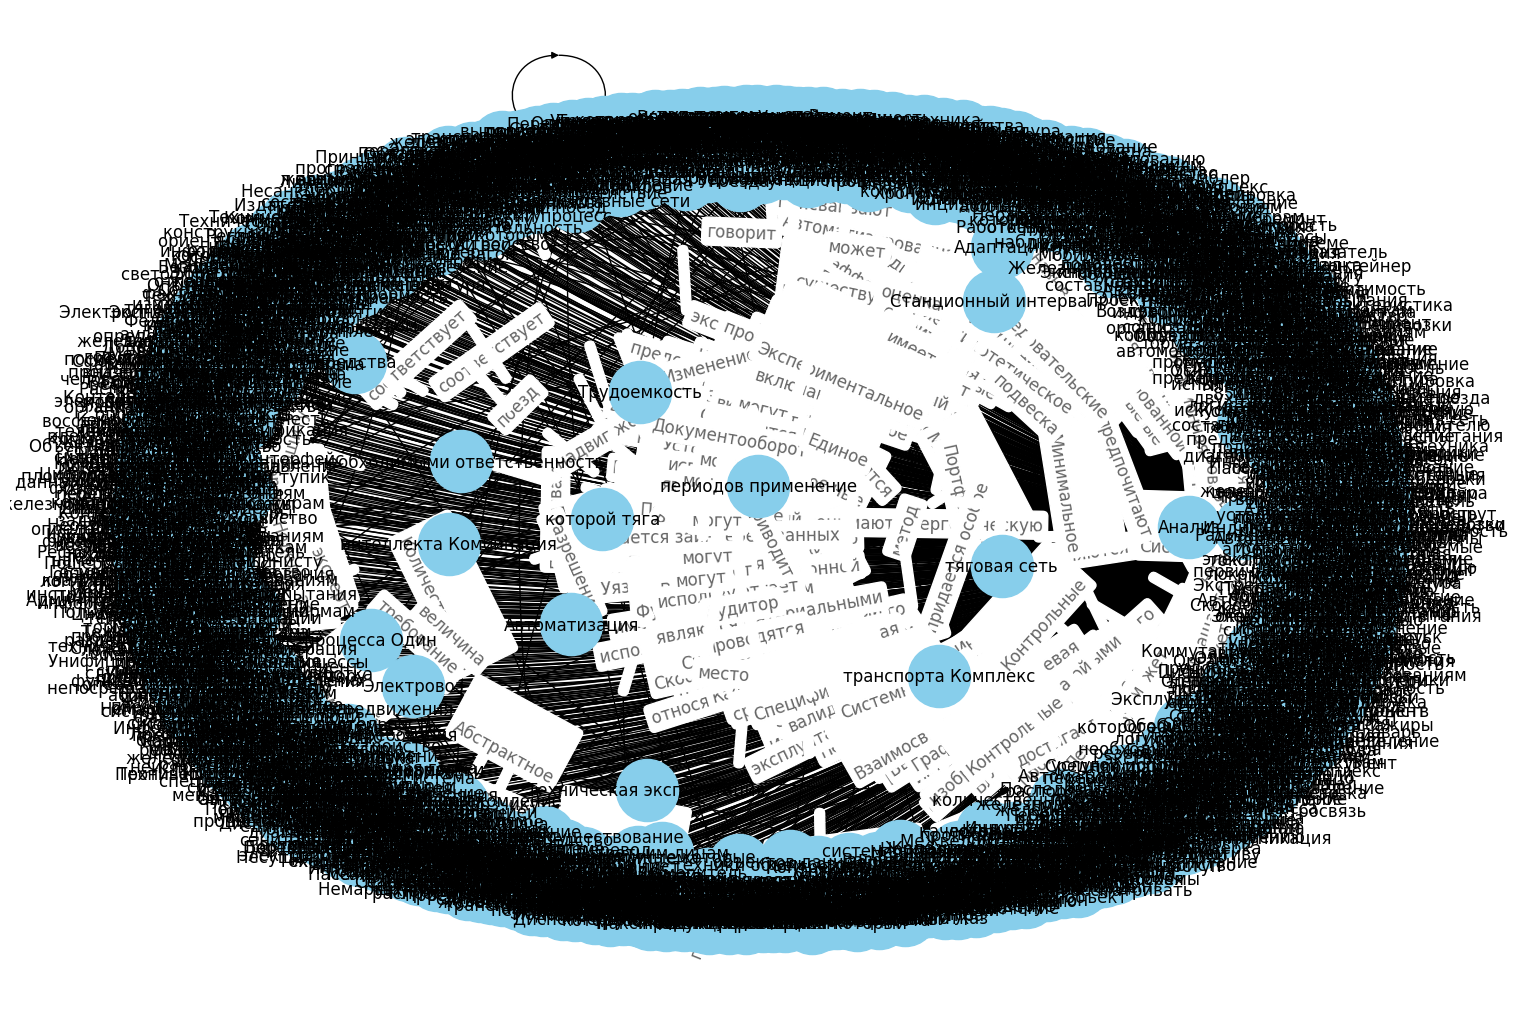

In [39]:
plt.figure(figsize=(15,10))

#pos = nx.nx_agraph.graphviz_layout(G, prog="fdp")
pos = nx.spring_layout(G, k=1)

node_color = "skyblue"
edge_color = "black"

nx.draw(G, pos=pos, with_labels=True, node_color=node_color, edge_color=edge_color, cmap=plt.cm.Dark2, 
        node_size=2000, connectionstyle='arc3,rad=0.1')

nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5, edge_labels=nx.get_edge_attributes(G,'relation'),
                             font_size=12, font_color='black', alpha=0.6)
plt.show()

In [40]:
## top
dtf[:5]

,text,entity,relation,object,attribute
0,емеханика железнодорожная.,емеханика,железнодорожная,,
1,Термины и определения]\n\n28.101.,Термины,\n\n,,
2,"Релейный шкаф\n\nШкаф специальной конструкции,...",Релейный шкаф,\n\n,,
3,\n\n[статья 106 ГОСТ Р 53431-2009 Автоматика и...,,\n\n,,
4,Термины и определения]\n\n28.102.,Термины,\n\n,,


In [41]:
dtf[(dtf["object"]!= '')&(dtf["relation"]!= '\n\n')]['entity'].value_counts()

                             39
ОАО Поставщик                 2
Отдельное несоответствие      2
продукции которые             2
крупнотоннажный контейнер     2
                             ..
Опытным образец               1
максимальная населенность     1
расчетная населенность        1
поршневой двигатель           1
Контрейлерная площадка        1
Name: entity, Length: 96, dtype: int64

In [42]:
## filter
f = "продукции которые"
tmp = dtf[((dtf["entity"]==f) | (dtf["object"]==f))&(dtf["object"]!= '')]

G = nx.from_pandas_edgelist(tmp, source="entity", target="object", edge_attr="relation", create_using=nx.DiGraph())

In [43]:
tmp

,text,entity,relation,object,attribute
7809,"Стратегия соответствия\n\nСтратегия, ориентиро...",продукции которые,Стратегия,соответствия,
7937,Разрешение на отклонение\n\nРазрешение на испо...,продукции которые,Разрешение,установленным требованиям,


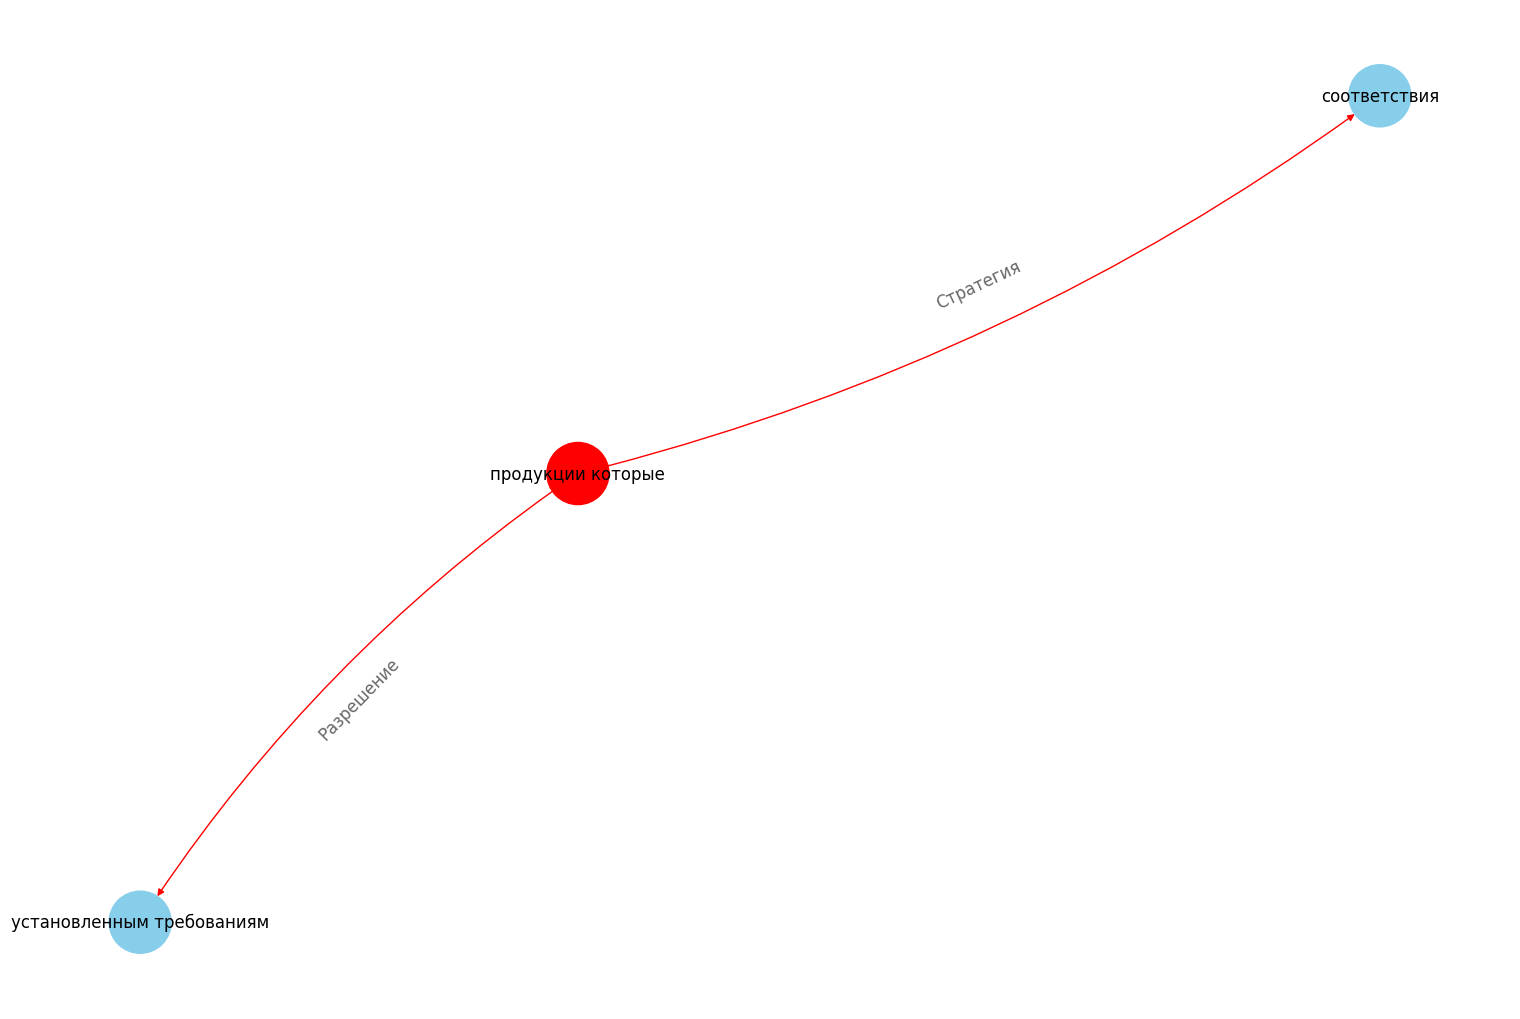

In [45]:
plt.figure(figsize=(15,10))

pos = nx.nx_agraph.graphviz_layout(G, prog="neato")
#pos = nx.spring_layout(G, k=2.5)

node_color = ["red" if node==f else "skyblue" for node in G.nodes]
edge_color = ["red" if edge[0]==f else "black" for edge in G.edges]

nx.draw(G, pos=pos, with_labels=True, node_color=node_color, edge_color=edge_color, cmap=plt.cm.Dark2, 
        node_size=2000, node_shape="o", connectionstyle='arc3,rad=0.1')

nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5, edge_labels=nx.get_edge_attributes(G,'relation'),
                             font_size=12, font_color='black', alpha=0.6)
plt.show()